In [1]:
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a15ee48d-19f1-e4e0-bba3-7fe69536b084)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Custom Dataset.zip"

Archive:  /content/drive/MyDrive/Custom Dataset.zip
   creating: Custom Dataset/
   creating: Custom Dataset/1/
  inflating: Custom Dataset/1/1_0.jpg  
  inflating: Custom Dataset/1/1_1.jpg  
  inflating: Custom Dataset/1/1_10.jpg  
  inflating: Custom Dataset/1/1_100.jpg  
  inflating: Custom Dataset/1/1_101.jpg  
  inflating: Custom Dataset/1/1_102.jpg  
  inflating: Custom Dataset/1/1_103.jpg  
  inflating: Custom Dataset/1/1_104.jpg  
  inflating: Custom Dataset/1/1_105.jpg  
  inflating: Custom Dataset/1/1_106.jpg  
  inflating: Custom Dataset/1/1_107.jpg  
  inflating: Custom Dataset/1/1_108.jpg  
  inflating: Custom Dataset/1/1_109.jpg  
  inflating: Custom Dataset/1/1_11.jpg  
  inflating: Custom Dataset/1/1_110.jpg  
  inflating: Custom Dataset/1/1_111.jpg  
  inflating: Custom Dataset/1/1_112.jpg  
  inflating: Custom Dataset/1/1_113.jpg  
  inflating: Custom Dataset/1/1_114.jpg  
  inflating: Custom Dataset/1/1_115.jpg  
  inflating: Custom Dataset/1/1_116.jpg  
  inflating:

In [5]:
custom_dataset = "/content/Custom Dataset"

In [6]:
glob.glob(custom_dataset + '/*')

['/content/Custom Dataset/3',
 '/content/Custom Dataset/4',
 '/content/Custom Dataset/1',
 '/content/Custom Dataset/2']

In [7]:
total_images = len(glob.glob(custom_dataset + '/*/*'))
total_images

# total images = 942

942

## Train-Test Split

In [8]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import splitfolders

In [10]:
splitfolders.ratio(input = custom_dataset,
                  output = 'custom_images_1to4',
                  ratio=(0.75, 0.15, 0.1))

Copying files: 942 files [00:00, 6059.08 files/s]


## Assign the class-names

In [11]:
labels = []
images = []
for i in (glob.glob('./custom_images_1to4/*/*/*')):
    images.append(i)
    label = i.split('_')[2][-1]
    labels.append(label)

In [12]:
images[720], labels[720]

('./custom_images_1to4/train/1/1_137.jpg', '1')

In [13]:
class_names = ['1', '2', '3', '4']

## Visualize Random Images

In [14]:
import random
import cv2
import numpy as np
import matplotlib.image as mpimg

Text(0.5, 1.0, '1')

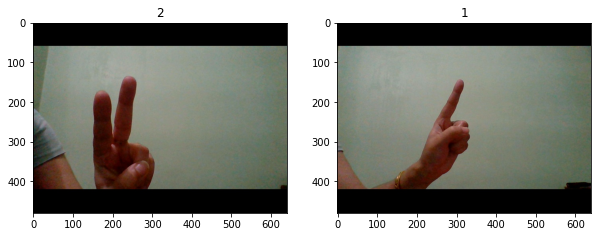

In [16]:
random_sample = random.sample(images, 2)

plt.figure(figsize=(10,7))

img1 = mpimg.imread(random_sample[0])
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title(random_sample[0].split('_')[2][-1])

img2 = mpimg.imread(random_sample[1])
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title(random_sample[1].split('_')[2][-1])


In [17]:
images_tensor = tf.constant(images)

## Preprocessing the images

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, Conv2D, Flatten

In [22]:
# Assign the variables according to train, val and test sets

training_data = './custom_images_1to4/train/'
validation_data = './custom_images_1to4/val/'
test_data = './custom_images_1to4/test/'

In [23]:
# Set the random Seed

tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
# Import data from directories and turn it into batches

training_images = train_datagen.flow_from_directory(directory= training_data,
                                                   target_size= (224,224),
                                                   batch_size = 16,
                                                   class_mode="categorical")

validation_images = test_datagen.flow_from_directory(directory= validation_data,
                                                   target_size= (224,224),
                                                   batch_size = 16,
                                                   class_mode="categorical")


Found 705 images belonging to 4 classes.
Found 140 images belonging to 4 classes.


In [34]:
pip install --upgrade tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import tensorflow_hub as hub

### **Get links for Resnet & Efficient Models from Tensorhub official Website**

In [36]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

### **Defining the model  --> Resnet Model + LAst layer( classes =4)**

In [37]:
def create_model(model_url, num_classes=10):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=(224,224)+(3,)) 
    model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
    return model  

## **Callbacks**

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback




### **Creating CallBacks:** :


#### **1. For comparision on Tensorboard**

In [38]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

#### **2. Model Checkpoint Callbacks** - to save model's progress while training

In [39]:
checkpoint_path = "/content/custom_images_1to4/model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## **Setting Mixed Precision Training**

In [40]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [41]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## **Custom Model**

### **Creating custom Model**

In [42]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation
from tensorflow.keras import Sequential

In [43]:
model_2 = Sequential()

model_2.add(Conv2D(150, (3, 3), input_shape=( 224, 224, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(200, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(215, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))


model_2.add(Conv2D(190, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten()) 
model_2.add(Dense(300))
model_2.add(Activation('relu'))

model_2.add(Dense(4))
model_2.add(Activation('softmax'))

model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [44]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 150)     4200      
                                                                 
 activation_6 (Activation)   (None, 222, 222, 150)     0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 150)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 200)     270200    
                                                                 
 activation_7 (Activation)   (None, 109, 109, 200)     0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 200)      0         
 2D)                                                  

### **Checking layer dtype policies (if mixed precision is used)**

In [47]:
for layer in model_2.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

conv2d_4 True float32 <Policy "mixed_float16">
activation_6 True float32 <Policy "mixed_float16">
max_pooling2d_4 True float32 <Policy "mixed_float16">
conv2d_5 True float32 <Policy "mixed_float16">
activation_7 True float32 <Policy "mixed_float16">
max_pooling2d_5 True float32 <Policy "mixed_float16">
conv2d_6 True float32 <Policy "mixed_float16">
activation_8 True float32 <Policy "mixed_float16">
max_pooling2d_6 True float32 <Policy "mixed_float16">
conv2d_7 True float32 <Policy "mixed_float16">
activation_9 True float32 <Policy "mixed_float16">
max_pooling2d_7 True float32 <Policy "mixed_float16">
flatten_1 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
activation_10 True float32 <Policy "mixed_float16">
dense_3 True float32 <Policy "mixed_float16">
activation_11 True float32 <Policy "mixed_float16">


### **Fitting the Custom Model**

In [50]:
history_2 = model_2.fit(training_images,
                        epochs=10,
                        validation_data=validation_images,
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="Custom Model"),
                                   model_checkpoint])

Saving TensorBoard log files to: tensorflow_hub/Custom Model/20221106-162343
Epoch 1/10
45/45 [==============================] - 9s 200ms/step - loss: 0.0379 - accuracy: 0.9901 - val_loss: 0.0107 - val_accuracy: 0.9929
Epoch 2/10
45/45 [==============================] - 9s 206ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 3/10
45/45 [==============================] - 9s 194ms/step - loss: 1.3914e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/10
45/45 [==============================] - 9s 195ms/step - loss: 4.6773e-05 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/10
45/45 [==============================] - 9s 189ms/step - loss: 3.1459e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/10
45/45 [==============================] - 9s 188ms/step - loss: 2.3358e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/10
45/45 [==============================] - 9s 

### **Predicting the custom model**

#### **Load and preprocess the new images**

In [54]:
def prepare_test_image(image):
    # Step 1 : Read the image
    test_img = tf.io.read_file(image)

    #Step 2: Decode the image in tensor
    test_img = tf.image.decode_image(test_img)

    #Step 3: Resize the image:
    test_img = tf.image.resize(test_img, size = [224, 224])

    # Step 4: Rescale the image:
    test_img = test_img/255.

    #Step 5: Convert into 4D
    test_img = tf.expand_dims(test_img, axis=0)
    
    return test_img

#### **Plot the predicted result**

In [55]:
def plot_predicted_output (test_image, model = model_2, class_names = class_names):
    # Step 1 : Load and preprocess the test image
    testimage = prepare_test_image(test_image)

    # Step 2 : Predict
    prediction_output = model.predict(testimage)
    print(prediction_output)
    print(type(prediction_output))

    # Step 3 : Find out the predicted class
    if len(prediction_output[0]) > 1:
        pred_class = class_names[tf.argmax(prediction_output[0])]
        print("Class : ", pred_class)
    else:
        pred_class = class_names[int(tf.round(prediction_output[0]))]
        print("Class : ",pred_class)

    # Step 4 : Visualize the test image + PREDICTED CLASS
    plt.figure()
    plt.imshow(tf.squeeze(testimage))
    plt.title(f" Predicted Class : {pred_class}")
    plt.axis = False

#### **Testing a Single Image from Test Set**

1/1 [==============================] - 0s 24ms/step
[[0.000e+00 9.985e-01 1.307e-03 2.384e-04]]
<class 'numpy.ndarray'>
Class :  2


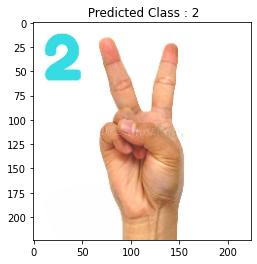

In [75]:
# prepare_test_image(r'D:\HAND RECOGNITION SYSTEMS\Code\Custom Dataset\3/3_18.jpg')
# plot_predicted_output('/content/custom_images_1to4/test/2/2_136.jpg')
plot_predicted_output('/content/s6.jpg')

#### **Evaluating on all Test Images**

In [ ]:
model_2.evaluate(test_images)

7/7 [==============================] - 1s 156ms/step - loss: 5.0928e-05 - accuracy: 1.0000


[5.092757419333793e-05, 1.0]

#### **Plotting the accuracy and Loss Curves**

In [ ]:
history_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
import pandas as pd

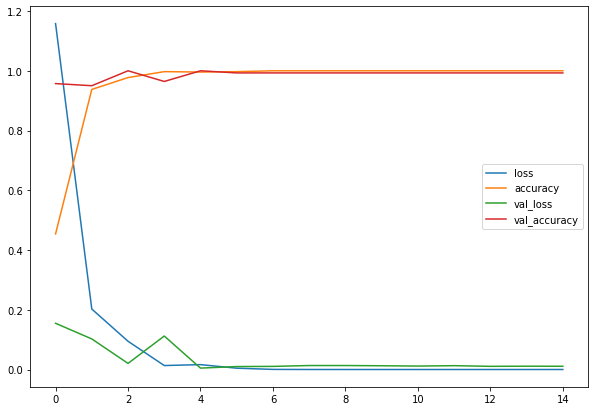

In [ ]:
df = pd.DataFrame(history_2.history)
df.plot(figsize=(10, 7))

## **Custom Model with Augmented dataset**

### **Data Augmentation**

In [ ]:
# Set the random Seed

tf.random.set_seed(42)


#Data Augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                   rotation_range= 0.4,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='constant')


test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Import data from directories and turn it into batches

augmented_training_images = train_datagen_augmented.flow_from_directory(directory = training_data,
                                                                        target_size = (224,224),
                                                                        batch_size = 16,
                                                                        shuffle=False)

augmented_validation_images = train_datagen_augmented.flow_from_directory(directory=validation_data,
                                                     target_size=(224,224),
                                                     batch_size=16,
                                                     shuffle=False)

test_images = test_datagen.flow_from_directory(directory=test_data,
                                              target_size = (224,224),
                                               batch_size = 16
                                              )

Found 705 images belonging to 4 classes.
Found 140 images belonging to 4 classes.
Found 97 images belonging to 4 classes.


In [ ]:
# original_images, original_labels = training_images.next()

augmented_images, augmented_labels = augmented_training_images.next()


### **Visualizing Augmented Images**

Random image number : 2


Text(0.5, 1.0, 'Augmented Image')

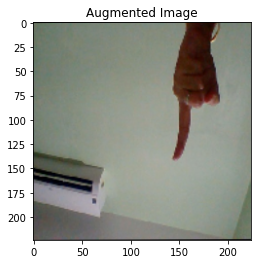

In [ ]:
import random
random_number = random.randint(0,15)
print(f"Random image number : {random_number}")

#Visualize Augmented Image
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title('Augmented Image')
# plt.axis(False)

### **Defining the Custom Model - Same as above model (model_2)**

In [ ]:
model_2_aug = Sequential()

model_2_aug.add(Conv2D(150, (3, 3), input_shape=( 224, 224, 3)))
model_2_aug.add(Activation('relu'))
model_2_aug.add(MaxPooling2D(pool_size=(2,2)))

model_2_aug.add(Conv2D(200, (3, 3)))
model_2_aug.add(Activation('relu'))
model_2_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_2_aug.add(Conv2D(215, (3, 3)))
model_2_aug.add(Activation('relu'))
model_2_aug.add(MaxPooling2D(pool_size=(2, 2)))


model_2_aug.add(Conv2D(190, (3, 3)))
model_2_aug.add(Activation('relu'))
model_2_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_2_aug.add(Flatten()) 
model_2_aug.add(Dense(300))
model_2_aug.add(Activation('relu'))

model_2_aug.add(Dense(4))
model_2_aug.add(Activation('softmax'))

model_2_aug.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

###  **<font color='red'> Using Data augmentation, accuracy drops.**

In [ ]:
history_2_aug = model_2_aug.fit(augmented_training_images,
                                epochs=15,
                                validation_data=augmented_validation_images)

Epoch 1/15
45/45 [==============================] - 14s 304ms/step - loss: 1.4875 - accuracy: 0.1376 - val_loss: 1.3859 - val_accuracy: 0.3000
Epoch 2/15
45/45 [==============================] - 13s 292ms/step - loss: 1.3867 - accuracy: 0.1830 - val_loss: 1.3856 - val_accuracy: 0.3000
Epoch 3/15
45/45 [==============================] - 13s 290ms/step - loss: 1.3864 - accuracy: 0.2993 - val_loss: 1.3849 - val_accuracy: 0.3000
Epoch 4/15
45/45 [==============================] - 13s 293ms/step - loss: 1.3862 - accuracy: 0.2993 - val_loss: 1.3845 - val_accuracy: 0.3000
Epoch 5/15
45/45 [==============================] - 14s 303ms/step - loss: 1.3853 - accuracy: 0.2993 - val_loss: 1.3840 - val_accuracy: 0.3000
Epoch 6/15
45/45 [==============================] - 14s 321ms/step - loss: 1.3845 - accuracy: 0.2993 - val_loss: 1.3838 - val_accuracy: 0.3000
Epoch 7/15
45/45 [==============================] - 16s 355ms/step - loss: 1.3847 - accuracy: 0.2993 - val_loss: 1.3832 - val_accuracy: 0.3000

### **Evaluating on all Test Images**

In [ ]:
model_2_aug.evaluate(test_images)

7/7 [==============================] - 1s 83ms/step - loss: 1.3812 - accuracy: 0.2990


[1.381217360496521, 0.2989690601825714]

### **Plotting the accuracy and Loss Curves**

In [ ]:
import pandas as pd
t = pd.DataFrame(history_2_aug.history)

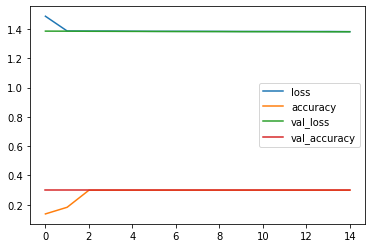

In [ ]:
t.plot()

# **Creating models using TensorFlow Hub**

## **Resnet Model** 

### **Creating the Model**

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=training_images.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 4)                 8196      
                                                                 
Total params: 23,572,996
Trainable params: 8,196
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile the model
resnet_model.compile(loss = 'categorical_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = 'accuracy')

### **Fitting the Model**

In [ ]:
# Fit the model

resnet_history = resnet_model.fit(training_images,
                                 epochs = 15,
                                 validation_data= validation_images,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221017-042907
Epoch 1/15
45/45 [==============================] - 22s 194ms/step - loss: 0.6974 - accuracy: 0.7589 - val_loss: 0.2517 - val_accuracy: 0.9714
Epoch 2/15
45/45 [==============================] - 6s 125ms/step - loss: 0.1519 - accuracy: 0.9773 - val_loss: 0.1286 - val_accuracy: 0.9786
Epoch 3/15
45/45 [==============================] - 6s 126ms/step - loss: 0.0818 - accuracy: 0.9915 - val_loss: 0.0894 - val_accuracy: 0.9857
Epoch 4/15
45/45 [==============================] - 5s 118ms/step - loss: 0.0542 - accuracy: 0.9986 - val_loss: 0.0787 - val_accuracy: 0.9857
Epoch 5/15
45/45 [==============================] - 8s 183ms/step - loss: 0.0401 - accuracy: 0.9986 - val_loss: 0.0639 - val_accuracy: 0.9857
Epoch 6/15
45/45 [==============================] - 5s 116ms/step - loss: 0.0301 - accuracy: 1.0000 - val_loss: 0.0518 - val_accuracy: 0.9857
Epoch 7/15
45/45 [==============================] - 6s 125ms/step - loss

### **Evaluation Curves - Accuracy & Loss Curves**

In [ ]:
def plot_evaluation_curves(history):
    
    loss = resnet_history.history['loss']
    val_loss = resnet_history.history['val_loss']
    
    accuracy = resnet_history.history['accuracy']
    val_accuracy = resnet_history.history['val_accuracy']
    
    epochs = range(len(resnet_history.history["loss"]))
    
    ## Plotting loss curves
#     plt.figure()
    plt.plot(epochs, loss, label = "Training Loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.title('Loss curves')
    plt.xlabel('Epochs')
    plt.legend()
    
    ## Plotting Accuracy curves
    plt.figure()   
    plt.plot(epochs, accuracy, label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.legend()


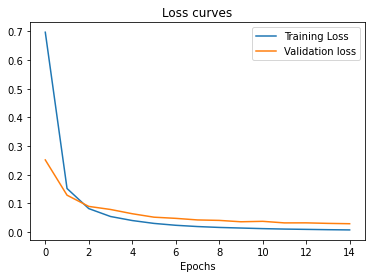

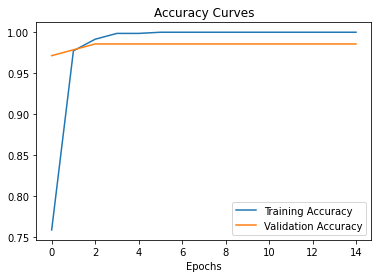

In [ ]:
plot_evaluation_curves(resnet_history)

### **Testing a Single Image from Test set**

1/1 [==============================] - 0s 35ms/step
[[1.6942613e-03 6.7966437e-04 9.8615682e-01 1.1469298e-02]]
<class 'numpy.ndarray'>
Class :  3


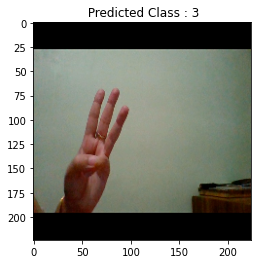

In [ ]:
plot_predicted_output('/content/custom_images_1to4/test/3/3_136.jpg', model = resnet_model)


### **Evaluation on all Test Images**

In [ ]:
resnet_model.evaluate(test_images)

7/7 [==============================] - 1s 125ms/step - loss: 0.0129 - accuracy: 1.0000


[0.012891309335827827, 1.0]

### **Plotting the accuracy and Loss curves**

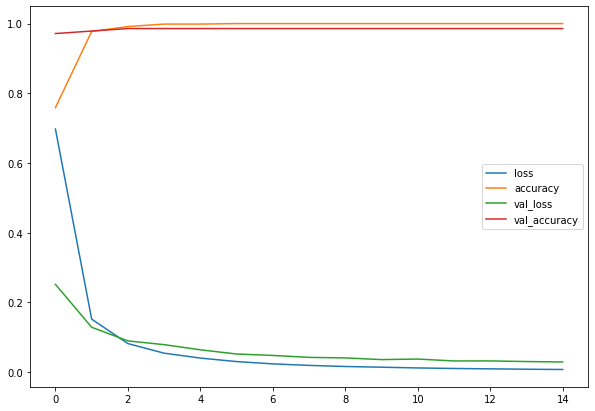

In [ ]:
df = pd.DataFrame(resnet_history.history)
df.plot(figsize=(10, 7))


## **Efficientnet Model**

### **Creating the model**

In [ ]:
efficientnet_model = create_model(model_url = efficientnet_url,
                                 num_classes = 4)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,688
Trainable params: 5,124
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# Compile the model

efficientnet_model.compile(loss = 'categorical_crossentropy',
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics = 'accuracy')

### **Fitting the Model**


In [ ]:
efficientnet_history = efficientnet_model.fit(training_images,
                                              epochs = 15,
                                              validation_data= validation_images,
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="EfficientNet"
                                                                                     )])

Saving TensorBoard log files to: tensorflow_hub/EfficientNet/20221017-043434
Epoch 1/15
45/45 [==============================] - 13s 208ms/step - loss: 0.5926 - accuracy: 0.9007 - val_loss: 0.2597 - val_accuracy: 0.9786
Epoch 2/15
45/45 [==============================] - 6s 124ms/step - loss: 0.1533 - accuracy: 0.9943 - val_loss: 0.1202 - val_accuracy: 0.9857
Epoch 3/15
45/45 [==============================] - 5s 116ms/step - loss: 0.0824 - accuracy: 0.9972 - val_loss: 0.0758 - val_accuracy: 0.9929
Epoch 4/15
45/45 [==============================] - 6s 137ms/step - loss: 0.0541 - accuracy: 0.9986 - val_loss: 0.0534 - val_accuracy: 0.9929
Epoch 5/15
45/45 [==============================] - 5s 117ms/step - loss: 0.0393 - accuracy: 1.0000 - val_loss: 0.0412 - val_accuracy: 0.9929
Epoch 6/15
45/45 [==============================] - 6s 126ms/step - loss: 0.0305 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 1.0000
Epoch 7/15
45/45 [==============================] - 7s 158ms/step - lo

### **Testing a single Image from Test Set**

1/1 [==============================] - 2s 2s/step
[[2.7074388e-04 2.0426542e-05 9.9825829e-01 1.4505172e-03]]
<class 'numpy.ndarray'>
Class :  3


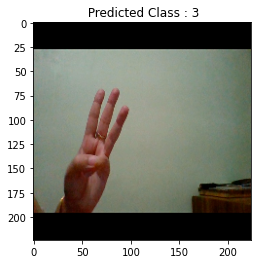

In [ ]:
plot_predicted_output('/content/custom_images_1to4/test/3/3_136.jpg', model = efficientnet_model)


### **Evaluation on all Test Images**

In [ ]:
efficientnet_model.evaluate(test_images)

7/7 [==============================] - 1s 81ms/step - loss: 0.0086 - accuracy: 1.0000


[0.008575700223445892, 1.0]

### **Plotting the accuracy and Loss curves**

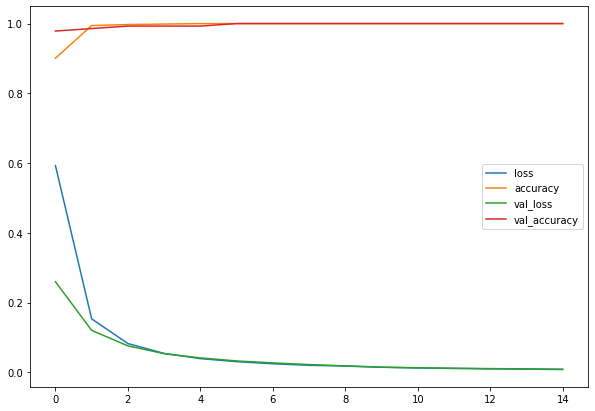

In [ ]:
df = pd.DataFrame(efficientnet_history.history)
df.plot(figsize=(10, 7))

# **TensorBoard**

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures" \
  --one_shot



***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=E7gEeyjQU8hjboQLJYFKxyrrk14309&prompt=consent&access_type=off

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/5jlJCZw7TB25za1rmvCNTw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures
	Id                   5jlJCZw7TB25za1rmvCNTw
	Created              2022-10-17 05:05:08 (26 seconds ago)
	Updated              2022-10-17 05:05:12 (22 seconds ago)
	Runs                 6
	Tags                 5
	Scalars              270
	Tensor bytes         0
	Binary object bytes  6896700
https://tensorboard.dev/experiment/O0nY4slMQ6WfRxXJK9uGSg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures
	Id                   O0nY4slMQ6WfRxXJK9uGSg
	Created              2022-10-14 06:06:54
	Updated              2022-10-14 06:06:56
	Runs                 6
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  5983890
https://tensorboard.dev/experiment/VW1hOtWbTEu